In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from ase.io import read
import torch
from tqdm import tqdm
from glob import glob
from pathlib import Path
from itertools import product
from mace import data, tools
from mace.tools import torch_geometric
from mace.tools.torch_tools import to_numpy
from contextlib import contextmanager


sns.set_theme(style="whitegrid")

In [3]:
test_files = sorted(glob("/home/hatemh/BOTNet-datasets/dataset_3BPA/test_*"))
checkpoint_files = sorted(glob("/home/hatemh/mace/experiments/checkpoints/*.model"))
num_tests = len(test_files)
num_checkpoints = len(checkpoint_files)
total_combinations = num_tests * num_checkpoints
total_combinations

96

In [4]:
z_table = tools.utils.AtomicNumberTable([1, 6, 7, 8])
r_max = 5.0
device = "cuda"

In [5]:
def parse_clip_grad(name: str):
    part = list(filter(lambda x: x.startswith("cg"), name.split("_")))

    if len(part) == 0:
        return -1

    return float(part[0].split("-")[-1])


def parse_loss_scale(name: str):
    part = list(filter(lambda x: x.startswith("ls"), name.split("_")))

    if len(part) == 0:
        return 1.0

    return float(part[0].split("-")[-1])


def parse_values(checkpoint_file: str):
    name = Path(checkpoint_file).stem
    seed = int(name.split("-")[-1])
    dtype = "float32" if name.find("fp64") == -1 else "float64"
    clip_grad = parse_clip_grad(name)
    loss_scale = parse_loss_scale(name)
    return {
        "seed": seed,
        "dtype": dtype,
        "clip_grad": clip_grad,
        "loss_scale": loss_scale,
    }


def make_loader(atoms_list):
    configs = data.utils.config_from_atoms_list(atoms_list)
    dataset = [
        data.AtomicData.from_config(c, z_table=z_table, cutoff=r_max) for c in configs
    ]
    loader = torch_geometric.dataloader.DataLoader(
        dataset=dataset, batch_size=32, shuffle=False, drop_last=False
    )
    return loader


@contextmanager
def default_dtype(dtype: torch.dtype):
    init = torch.get_default_dtype()
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(init)


def eval_model(checkpoint_file: str, test_file: str, device: str = device):
    model = torch.load(checkpoint_file)
    model.to(device)
    model_dtype = {p.dtype for p in model.parameters()}.pop()

    with default_dtype(model_dtype):
        atoms_list = read(test_file, index=":")
        loader = make_loader(atoms_list)
        errors = []

        for batch in tqdm(loader):
            batch = batch.to(device)
            target = to_numpy(batch.energy)
            output = model(batch.to_dict())
            pred = to_numpy(output["energy"])
            errors.append(np.abs(target - pred))

    del model
    del loader
    torch.cuda.empty_cache()

    errors = 1e3 * np.concatenate(errors, axis=0)

    return {
        **parse_values(checkpoint_file),
        "dataset": Path(test_file).stem,
        "mae (meV)": np.mean(errors),
        "rmse (meV)": np.sqrt(np.mean(errors**2)),
    }

In [6]:
records = [
    eval_model(cf, tf)
    for cf, tf in tqdm(product(checkpoint_files, test_files), total=total_combinations)
]
df = pd.DataFrame(records)
df

100%|██████████| 96/96 [49:09<00:00, 30.72s/it]


,seed,dtype,clip_grad,loss_scale,dataset,mae (meV),rmse (meV)
0,1702,float32,10.0,1.0,test_1200K,33.235085,47.221191
1,1702,float32,10.0,1.0,test_300K,2.384942,3.412175
2,1702,float32,10.0,1.0,test_600K,7.802451,11.975307
3,1702,float32,10.0,1.0,test_dih,13.574039,36.944691
4,285,float32,10.0,1.0,test_1200K,44.116520,61.096336
...,...,...,...,...,...,...,...
91,285,float32,-1.0,1.0,test_dih,5.731606,15.115848
92,43,float32,-1.0,1.0,test_1200K,23.958881,34.482853
93,43,float32,-1.0,1.0,test_300K,2.329941,3.302917
94,43,float32,-1.0,1.0,test_600K,6.495191,10.935568


In [7]:
df.to_parquet("eval_mace_sweep.parquet")

In [8]:
sweep_results = df.groupby(["dtype", "clip_grad", "loss_scale", "dataset"])[
    "rmse (meV)"
].describe()
sweep_results.sort_values(by=["mean"])

count       mean        std  \
dtype   clip_grad loss_scale dataset                                   
float64 -1.0      1000.0     test_300K     3.0   2.847039   0.204082   
                  1.0        test_300K     3.0   2.863910   0.204485   
float32 -1.0      1.0        test_300K     3.0   3.071532   0.336283   
                  1000.0     test_300K     3.0   3.099425   0.376478   
float64  10.0     1.0        test_300K     3.0   3.419978   0.215689   
float32  10.0     1.0        test_300K     3.0   3.479501   0.344735   
                  1000.0     test_300K     3.0   8.062960   3.203690   
float64 -1.0      1.0        test_600K     3.0  10.506742   0.196648   
                  1000.0     test_600K     3.0  10.530708   0.123310   
float32 -1.0      1.0        test_600K     3.0  10.546127   0.628851   
                  1000.0     test_600K     3.0  10.644958   0.683644   
float64 -1.0      1.0        test_dih      3.0  10.727352   1.642192   
                  1000.0     test_dih      3.0  10.752583   1.504423   
         10.0     1.0        test_600K     3.0  11.729941   0.358211   
float32  10.0     1.0        test_600K     3.0  11.873824   0.526261   
float64  10.0     1000.0     test_300K     3.0  12.555176   6.461553   
float32 -1.0      1.0        test_dih      3.0  14.640897   3.504800   
                  1000.0     test_dih      3.0  15.086642   3.619478   
         10.0     1000.0     test_600K     3.0  15.851529   2.581860   
float64  10.0     1000.0     test_600K     3.0  19.327126   5.354834   
                  1.0        test_dih      3.0  30.358709   1.961211   
float32  10.0     1.0        test_dih      3.0  33.435405   4.634168   
float64 -1.0      1000.0     test_1200K    3.0  33.499629   3.169439   
                  1.0        test_1200K    3.0  33.533492   3.331001   
float32 -1.0      1.0        test_1200K    3.0  34.177391   0.846582   
                  1000.0     test_1200K    3.0  34.212104   1.182588   
float64  10.0     1000.0     test_dih      3.0  42.702840   3.123457   
float32  10.0     1000.0     test_dih      3.0  42.971082   1.296929   
float64  10.0     1.0        test_1200K    3.0  52.138537   8.926682   
float32  10.0     1.0        test_1200K    3.0  56.688876   8.205749   
                  1000.0     test_1200K    3.0  74.166055  14.621897   
float64  10.0     1000.0     test_1200K    3.0  78.105008  19.385073   

                                               min        25%        50%  \
dtype   clip_grad loss_scale dataset                                       
float64 -1.0      1000.0     test_300K    2.621991   2.760510   2.899030   
                  1.0        test_300K    2.632460   2.785816   2.939172   
float32 -1.0      1.0        test_300K    2.685780   2.955839   3.225899   
                  1000.0     test_300K    2.666135   2.975853   3.285571   
float64  10.0     1.0        test_300K    3.276651   3.295949   3.315247   
float32  10.0     1.0        test_300K    3.173395   3.292785   3.412175   
                  1000.0     test_300K    6.209908   6.213310   6.216713   
float64 -1.0      1.0        test_600K   10.333608  10.399841  10.466074   
                  1000.0     test_600K   10.419576  10.464380  10.509185   
float32 -1.0      1.0        test_600K    9.820647  10.351407  10.882167   
                  1000.0     test_600K    9.861169  10.408312  10.955456   
float64 -1.0      1.0        test_dih     9.537551   9.790552  10.043554   
                  1000.0     test_dih     9.847713   9.884260   9.920808   
         10.0     1.0        test_600K   11.521648  11.523129  11.524610   
float32  10.0     1.0        test_600K   11.304213  11.639760  11.975307   
float64  10.0     1000.0     test_300K    5.457328   9.784837  14.112347   
float32 -1.0      1.0        test_dih    10.922842  13.019345  15.115848   
                  1000.0     test_dih    11.031333  13.635074  16.238815   
         10.0     1000.0     test_600K   14.353536  14.360897  14.368258

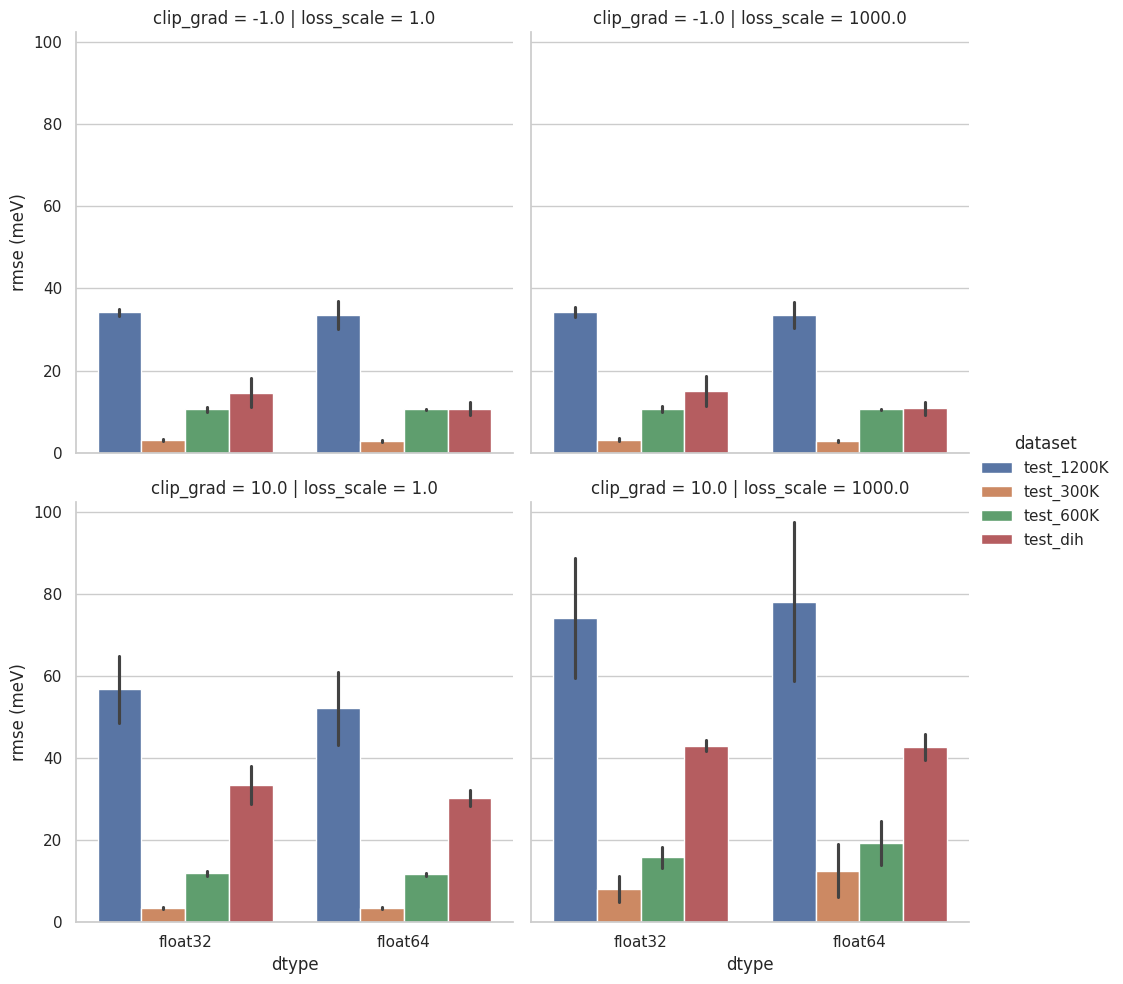

In [9]:
df = pd.read_parquet("eval_mace_sweep.parquet")
sns.catplot(
    data=df,
    x="dtype",
    y="rmse (meV)",
    col="loss_scale",
    row="clip_grad",
    hue="dataset",
    kind="bar",
    errorbar="sd",
)

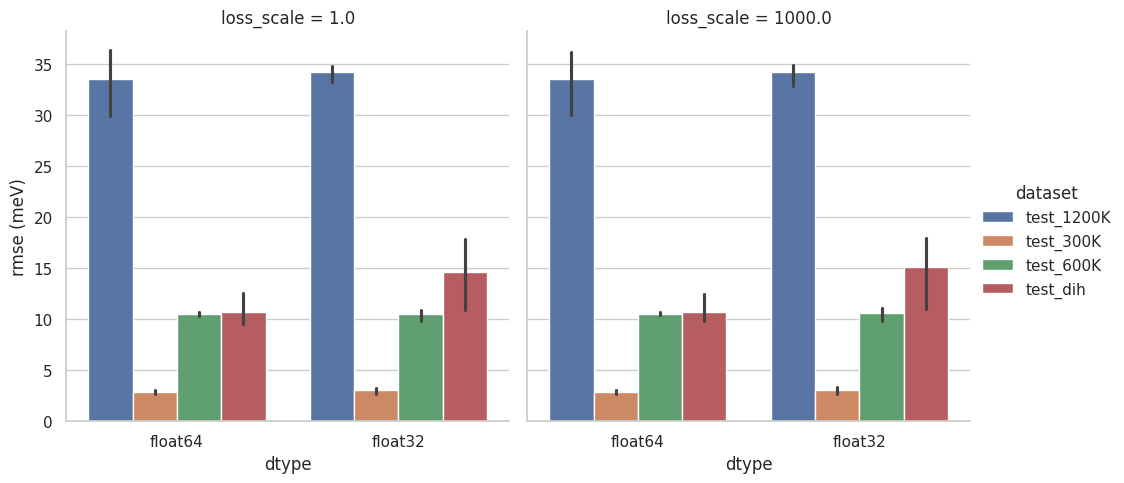

In [10]:
mask = df["clip_grad"] == -1
sns.catplot(
    data=df[mask],
    x="dtype",
    y="rmse (meV)",
    hue="dataset",
    col="loss_scale",
    kind="bar",
)

In [11]:
dataset = read("/home/hatemh/BOTNet-datasets/dataset_3BPA/test_dih.xyz", index=":")

alpha, beta, gamma = np.stack([d.info["dihedrals"] for d in dataset]).T
mask = (alpha == 71) & (beta == 120)
subset = [d for d, tf in zip(dataset, mask) if tf]
len(subset)

50

<Axes: xlabel='gamma', ylabel='E reference (eV)'>

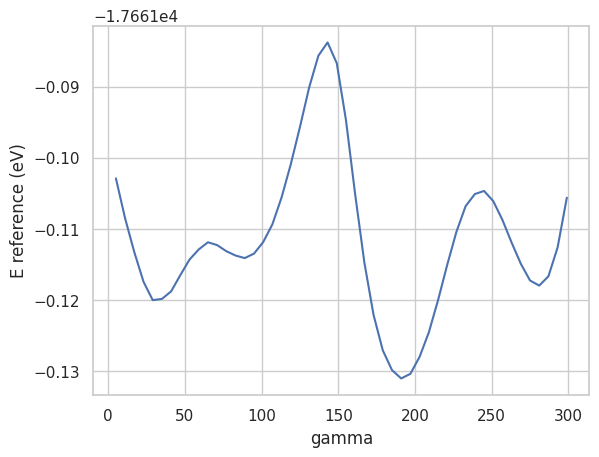

In [12]:
ref_df = pd.DataFrame(
    {
        "gamma": gamma[mask],
        "E reference (eV)": np.stack([d.info["energy"] for d in subset]),
    }
)
sns.lineplot(ref_df, x="gamma", y="E reference (eV)")

In [13]:
def eval_slice(checkpoint_file: str, dataset=subset, device: str = device, dtype=None):
    model = torch.load(checkpoint_file)
    model.to(device)
    model_dtype = {p.dtype for p in model.parameters()}.pop()
    dtype = model_dtype if dtype is None else dtype
    model.to(dtype)

    with default_dtype(dtype):
        loader = make_loader(dataset)
        preds = []
        errors = []

        for batch in tqdm(loader):
            batch = batch.to(device)
            target = to_numpy(batch.energy)
            output = model(batch.to_dict())
            pred = to_numpy(output["energy"])
            preds.append(pred)
            errors.append(np.abs(target - pred))

    del model
    del loader
    torch.cuda.empty_cache()

    alpha, beta, gamma = np.stack([d.info["dihedrals"] for d in dataset]).T

    errors = 1e3 * np.concatenate(errors, axis=0)
    results = pd.DataFrame(
        {
            "alpha": alpha,
            "beta": beta,
            "gamma": gamma,
            "E predicted (eV)": np.concatenate(preds, axis=0),
        }
    )

    for k, v in parse_values(checkpoint_file).items():
        results[k] = v

    results["eval_dtype"] = str(dtype).split(".")[-1]
    return results

In [14]:
checkpoints = (
    glob("checkpoints/model_fp64_run*.model")
    + glob("checkpoints/model_run*.model")
    + glob("checkpoints/model_fp64_ls-1000_run*.model")
    + glob("checkpoints/model_ls-1000_run*.model")
)
slice_df = pd.concat([eval_slice(c) for c in checkpoints])
slice_df.head()

100%|██████████| 2/2 [00:00<00:00,  4.21it/s]


,alpha,beta,gamma,E predicted (eV),seed,dtype,clip_grad,loss_scale,eval_dtype
0,71.0,120.0,5.0,-17661.107438,285,float64,-1,1.0,float64
1,71.0,120.0,11.0,-17661.112472,285,float64,-1,1.0,float64
2,71.0,120.0,17.0,-17661.116663,285,float64,-1,1.0,float64
3,71.0,120.0,23.0,-17661.120774,285,float64,-1,1.0,float64
4,71.0,120.0,29.0,-17661.123327,285,float64,-1,1.0,float64


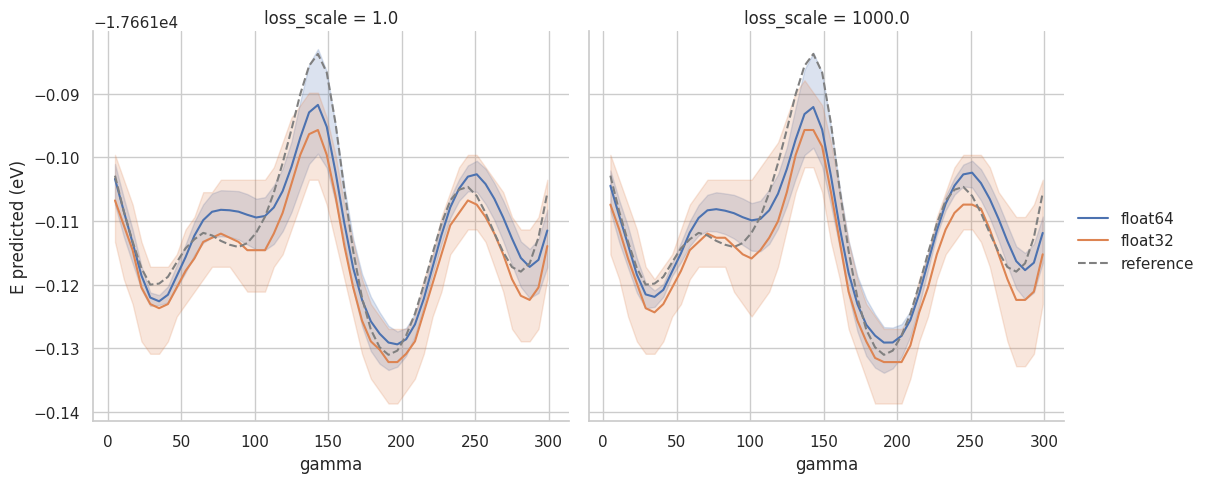

In [15]:
def minmax(x):
    return x.min(), x.max()


g = sns.relplot(
    data=slice_df,
    x="gamma",
    y="E predicted (eV)",
    hue="dtype",
    col="loss_scale",
    kind="line",
    errorbar=minmax,
)


for ax in g.axes.reshape(-1):
    h = ax.plot(
        ref_df["gamma"],
        ref_df["E reference (eV)"],
        "0.5",
        ls="--",
        label="DFT reference",
    )

labels = ["float64", "float32", "reference"]
handles = g.legend.legend_handles + h
g.legend.remove()
g.add_legend(dict(zip(labels, handles)))

100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


,alpha,beta,gamma,E predicted (eV),seed,dtype,clip_grad,loss_scale,eval_dtype
0,71.0,120.0,5.0,-17661.107422,285,float64,-1,1.0,float32
1,71.0,120.0,11.0,-17661.113281,285,float64,-1,1.0,float32
2,71.0,120.0,17.0,-17661.117188,285,float64,-1,1.0,float32
3,71.0,120.0,23.0,-17661.119141,285,float64,-1,1.0,float32
4,71.0,120.0,29.0,-17661.123047,285,float64,-1,1.0,float32
...,...,...,...,...,...,...,...,...,...
45,71.0,120.0,275.0,-17661.109939,1702,float64,-1,1.0,float64
46,71.0,120.0,281.0,-17661.113208,1702,float64,-1,1.0,float64
47,71.0,120.0,287.0,-17661.115105,1702,float64,-1,1.0,float64
48,71.0,120.0,293.0,-17661.114145,1702,float64,-1,1.0,float64


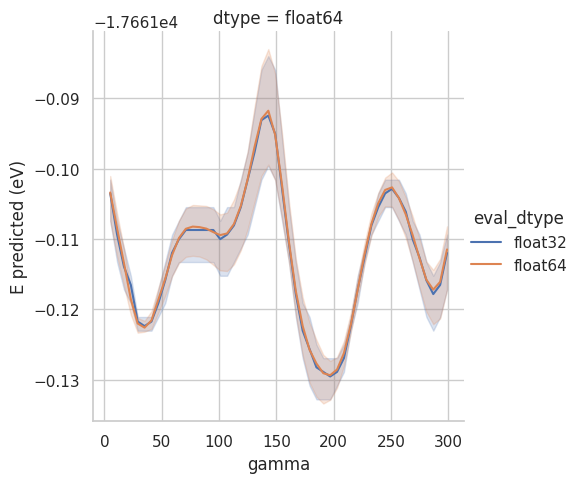

In [20]:
checkpoints = glob("checkpoints/model_fp64_run*.model")
eval_dtypes = [torch.float32, torch.float64]

slice_df = pd.concat(
    [
        eval_slice(c, dtype=dt, dataset=subset)
        for c, dt in product(checkpoints, eval_dtypes)
    ]
)

g = sns.relplot(
    data=slice_df,
    x="gamma",
    y="E predicted (eV)",
    hue="eval_dtype",
    kind="line",
    col="dtype",
    errorbar=minmax,
)
slice_df

In [22]:
slice_df.shape

(100, 9)

In [23]:
slice_df.shape

(100, 9)

In [47]:
x = slice_df[slice_df["eval_dtype"] == "float64"][["gamma", "E predicted (eV)"]]
y = slice_df[slice_df["eval_dtype"] == "float32"][["gamma", "E predicted (eV)"]]
x - y, x["gamma"][35]

(    gamma  E predicted (eV)
 0     0.0         -0.000016
 1     0.0          0.000809
 2     0.0          0.000524
 3     0.0          0.000319
 4     0.0         -0.000281
 5     0.0         -0.000143
 6     0.0         -0.000597
 7     0.0          0.000657
 8     0.0         -0.000044
 9     0.0         -0.000166
 10    0.0          0.000583
 11    0.0         -0.000014
 12    0.0          0.000259
 13    0.0          0.000206
 14    0.0          0.000030
 15    0.0         -0.000186
 16    0.0          0.000052
 17    0.0         -0.000786
 18    0.0          0.001072
 19    0.0         -0.000206
 20    0.0         -0.000687
 21    0.0          0.000949
 22    0.0         -0.000568
 23    0.0          0.000885
 24    0.0          0.000200
 25    0.0          0.000484
 26    0.0          0.000054
 27    0.0          0.000326
 28    0.0          0.000451
 29    0.0          0.000432
 30    0.0          0.000386
 31    0.0         -0.000592
 32    0.0         -0.000066
 33    0.0    

In [28]:
def relax(conf):
    from ase.constraints import FixAtoms
    from ase.optimize import BFGS, FIRE

    conf.set_constraint(
        [
            FixAtoms(indices=[1, 5, 13, 14]),
            FixAtoms(indices=[13, 5, 1, 4]),
            FixAtoms(indices=[5, 13, 14, 18]),
            FixAtoms(indices=[1, 4, 6, 8]),
        ]
    )

    # now optimize the geometry with multiple optimizers to ensure convergence
    opt = BFGS(conf, logfile=None)
    opt.run(fmax=5e-3, steps=250)

    opt2 = FIRE(conf, logfile=None)
    opt2.run(fmax=5e-3, steps=100)

    opt3 = BFGS(conf, logfile=None)
    opt3.run(fmax=5e-3, steps=100)

    return conf.get_potential_energy()

In [29]:
from mace.calculators import MACECalculator


train_dtype = {
    "float32": "checkpoints/model_run*.model",
    "float64": "checkpoints/model_fp64_run*.model",
}

calc_dtype = ["float32", "float64"]
dfs = []

for t, c in product(train_dtype.keys(), calc_dtype):
    calc = MACECalculator(model_paths=train_dtype[t], device=device, default_dtype=c)
    E = []
    for conf in tqdm(subset):
        conf.calc = calc
        E.append(relax(conf))

    df = pd.DataFrame({"gamma": gamma[mask], "E (eV)": np.stack(E)})
    df["train dtype"] = t
    df["inference dtype"] = c
    dfs.append(df)

dfs = pd.concat(dfs)
dfs.head()

Running committee mace with 3 models


100%|██████████| 50/50 [03:31<00:00,  4.22s/it]


Running committee mace with 3 models
Default dtype float64 does not match model dtype float32, converting models to float64.


100%|██████████| 50/50 [00:06<00:00,  7.69it/s]


Running committee mace with 3 models
Default dtype float32 does not match model dtype float64, converting models to float32.


100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


Running committee mace with 3 models


100%|██████████| 50/50 [00:06<00:00,  8.20it/s]


,gamma,E (eV),train dtype,inference dtype
0,5.0,-17661.107422,float32,float32
1,11.0,-17661.113281,float32,float32
2,17.0,-17661.117188,float32,float32
3,23.0,-17661.121094,float32,float32
4,29.0,-17661.125000,float32,float32


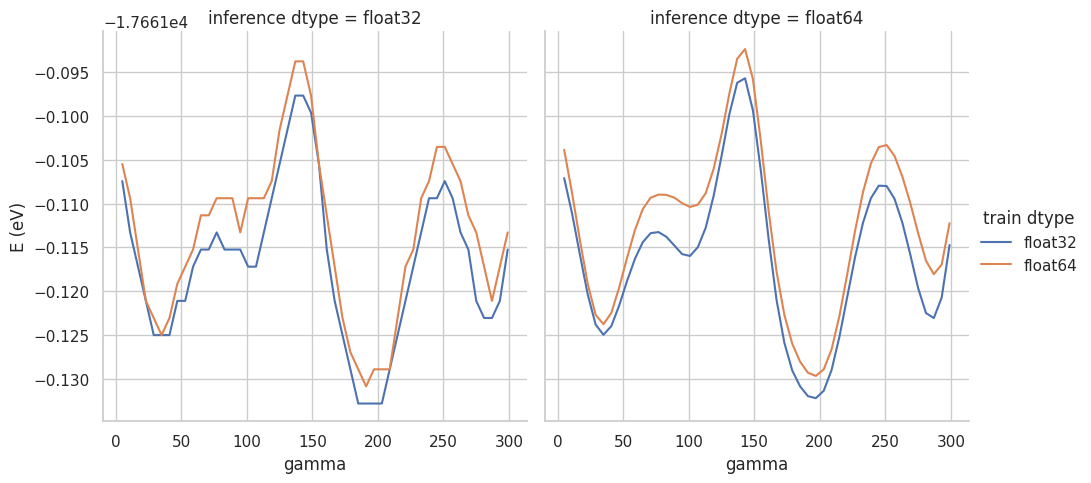

In [30]:
sns.relplot(
    data=dfs,
    x="gamma",
    y="E (eV)",
    hue="train dtype",
    kind="line",
    col="inference dtype",
)